In [1]:
import rebound as rb
from celmech.symplectic_evolution_operators import SecularDFTermsEvolutionOperator
from celmech.secular import SecularSystemSimulation,LaplaceLagrangeSystem
import numpy as np
from celmech.nbody_simulation_utilities import align_simulation
from celmech import Poincare,PoincareHamiltonian

import matplotlib.pyplot as plt

In [2]:
def get_sim(scale= 0.05,Nplanet = 3):
    sim = rb.Simulation()
    sim.add(m=1)
    for i in range(1,Nplanet+1):
        sim.add(m=i * 1e-5 , a = 2**i, 
                e = np.random.rayleigh(scale),
                inc = np.random.rayleigh(scale),
                l = 'uniform',
                pomega = 'uniform',
                Omega = 'uniform'
               )
    sim.move_to_com()
    align_simulation(sim)
    return sim


In [3]:
def get_relative_energy_error(dfOp,qp0,method,h,T,rtol = 1e-15):
    dfOp.rkmethod = method
    dfOp.rtol = rtol
    dfOp.dt = h
    E0 = dfOp.Hamiltonian_from_qp_vec(qp0)
    Nsteps = int(np.ceil(T / h))
    qp = qp0.copy()
    for _ in xrange(Nsteps):
        qp = dfOp.implicit_rk_step(qp)
    Ef = dfOp.Hamiltonian_from_qp_vec(qp)
    return np.abs((E0-Ef)/E0)

In [4]:
sim = get_sim()
pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)
llsys = LaplaceLagrangeSystem.from_Poincare(pvars)
Tsec = llsys.Tsec
dfOp = SecularDFTermsEvolutionOperator.fromOrderRange(pvars,Tsec / 100,2,4,max_iter = 25,rtol = 1.e-15)
state_vec = pham.state_to_list(pvars)
qpvec0 = dfOp.state_vec_to_qp_vec(state_vec)

In [5]:
methods = ['LobattoIIIB','GL4','GL6']
N = 12
hsteps =  np.logspace(-3.,-1.25,N) * Tsec
Tfinal = 0.1*Tsec

dEbyE_dict = {method:np.zeros(N) for method in methods}
for method in methods:
    dfOp.rkmethod = method
    dEbyE = dEbyE_dict[method]
    for i,h in enumerate(hsteps):        
        dEbyE[i] = get_relative_energy_error(dfOp,qpvec0,method,h,Tfinal)

/Users/shadden/Projects/celmech/celmech/symplectic_evolution_operators.py:1037: UserWarning: 'implicit_rk_step' reached maximum number of iterations (25)
  warnings.warn("'implicit_rk_step' reached maximum number of iterations ({})".format(max_iter))


method: LobattoIIIB, scaling: h^4.00
method: GL4, scaling: h^3.89
method: GL6, scaling: h^5.23


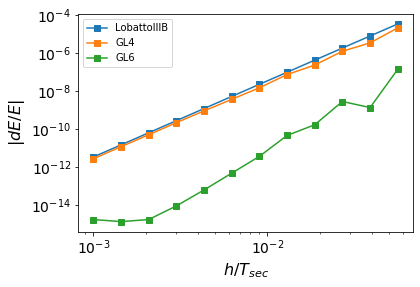

In [6]:
for method,dEbyE in dEbyE_dict.items():
    
    plt.loglog(hsteps/Tsec,dEbyE,'s-',label=method)
    x = np.log10(hsteps[dEbyE>1e-13]/Tsec)
    y = np.log10(dEbyE[dEbyE>1e-13])
    A = np.vstack((np.ones(len(x)) , x)).T
    answer = np.linalg.lstsq(A,y,rcond=-1)
    
    print("method: {0}, scaling: h^{1:.2f}".format(method,answer[0][1]))
    
plt.legend()    
plt.ylabel(r'$|dE/E|$',fontsize=16)
plt.xlabel(r'$h/T_{sec}$',fontsize=16)
plt.tick_params(labelsize=14)
